# ROMY Status File

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import obspy as obs
import matplotlib.colors

from pandas import DataFrame, merge
from andbro__save_to_pickle import __save_to_pickle

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [3]:
from functions.load_beat import __load_beat
from functions.load_mlti import __load_mlti
from functions.get_mlti_intervals import __get_mlti_intervals

## Configurations

In [4]:
config = {}


config['tbeg'] = obs.UTCDateTime("2023-09-01")
config['tend'] = obs.UTCDateTime("2023-12-31")
# config['tend'] = obs.UTCDateTime("2023-09-25")

config['ring'] = "U"

config['path_to_figures'] = archive_path+f"romy_plots/{config['tbeg'].year}/R{config['ring']}/status/"

config['path_to_data'] = archive_path+f"temp_archive/"


### Load Status Data

In [5]:
from functions.load_status import __load_status

In [6]:
statusU = __load_status(config['tbeg'], config['tend'], "U", config['path_to_data'])

 -> no such file: 2023/BW/RU/RU_2023-10-27_status.pkl
 -> no such file: 2023/BW/RU/RU_2023-10-28_status.pkl
 -> no such file: 2023/BW/RU/RU_2023-10-29_status.pkl
 -> no such file: 2023/BW/RU/RU_2023-10-30_status.pkl
 -> no such file: 2023/BW/RU/RU_2023-11-09_status.pkl
 -> no such file: 2023/BW/RU/RU_2023-11-29_status.pkl


In [7]:
statusU[statusU.times_utc > obs.UTCDateTime("2023-09-06 23:59")]

,times_utc,times_utc_sec,quality,fsagnac,mlti,ac_threshold,dc_threshold
2,2023-09-06T23:59:30.000000Z,518370.0,1.0,1.0,1.0,1.0,1.0
3,2023-09-07T00:00:30.000000Z,518430.0,1.0,1.0,1.0,1.0,1.0
4,2023-09-07T00:01:30.000000Z,518490.0,1.0,1.0,1.0,1.0,1.0
5,2023-09-07T00:02:30.000000Z,518550.0,1.0,1.0,1.0,1.0,1.0
6,2023-09-07T00:03:30.000000Z,518610.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...
1438,2023-12-30T23:55:30.000000Z,10454130.0,1.0,1.0,1.0,1.0,1.0
1439,2023-12-30T23:56:30.000000Z,10454190.0,1.0,1.0,1.0,1.0,1.0
0,2023-12-30T23:57:30.000000Z,10454250.0,1.0,1.0,1.0,1.0,1.0
1,2023-12-30T23:58:30.000000Z,10454310.0,1.0,1.0,1.0,1.0,1.0


In [8]:
statusV = __load_status(config['tbeg'], config['tend'], "V", config['path_to_data'])

 -> no such file: 2023/BW/RV/RV_2023-10-09_status.pkl
 -> no such file: 2023/BW/RV/RV_2023-10-10_status.pkl
 -> no such file: 2023/BW/RV/RV_2023-10-11_status.pkl
 -> no such file: 2023/BW/RV/RV_2023-10-12_status.pkl
 -> no such file: 2023/BW/RV/RV_2023-10-13_status.pkl
 -> no such file: 2023/BW/RV/RV_2023-10-14_status.pkl
 -> no such file: 2023/BW/RV/RV_2023-10-15_status.pkl
 -> no such file: 2023/BW/RV/RV_2023-10-16_status.pkl
 -> no such file: 2023/BW/RV/RV_2023-10-17_status.pkl
 -> no such file: 2023/BW/RV/RV_2023-10-18_status.pkl


In [9]:
statusZ = __load_status(config['tbeg'], config['tend'], "Z", config['path_to_data'])

 -> no such file: 2023/BW/RZ/RZ_2023-11-22_status.pkl


### Define Variables

### Plotting

In [10]:
def __makelplot_single_status(df, ring):

    names = ["quality", "fsagnac", "mlti", "ac_threshold", "dc_threshold"]
    bars = np.ones(len(names))-0.5

    arr = np.ones((len(names), df['quality'].size))

    for _n, name in enumerate(names):
        arr[_n] *= df[name]

    time_scaling = 1

    cmap = matplotlib.colors.ListedColormap(['darkred', 'green'])

    font = 12

    fig, ax = plt.subplots(1, 1, figsize=(15, 4))

    c = ax.pcolormesh(df.times_utc_sec*time_scaling, names, arr, cmap=cmap, rasterized=False, alpha=0.8)

    for _k, bar in enumerate(bars):
        ax.axhline(bar+_k, color="w", alpha=0.8, lw=2)

    # ax.set_xlabel("Time (days)")

    ax.set_title(f"Quality Status of R{ring}")

    ref_date = df.times_utc.iloc[0]
    tcks = ax.get_xticks()
    tcklbls = [str((obs.UTCDateTime(ref_date)+t).date) for t in tcks]
    ax.set_xticklabels(tcklbls)

    ax.tick_params(axis='y', labelsize=font)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show();
    return fig

/tmp/ipykernel_196622/2538545562.py:19: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = ax.pcolormesh(df.times_utc_sec*time_scaling, names, arr, cmap=cmap, rasterized=False, alpha=0.8)
/tmp/ipykernel_196622/2538545562.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tcklbls)


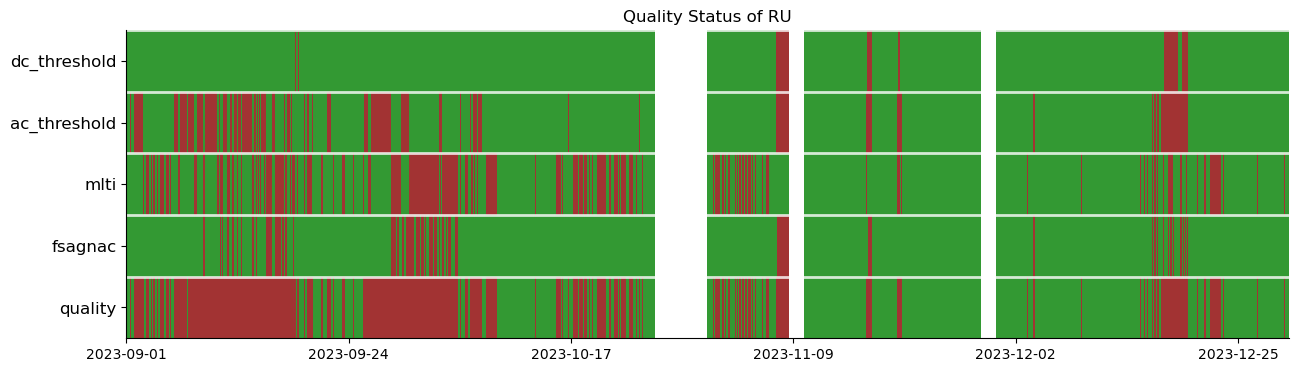

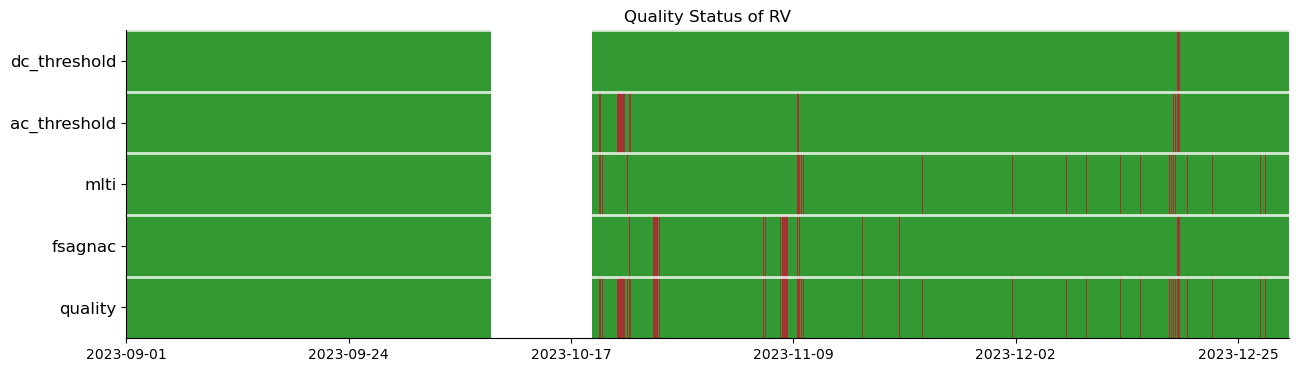

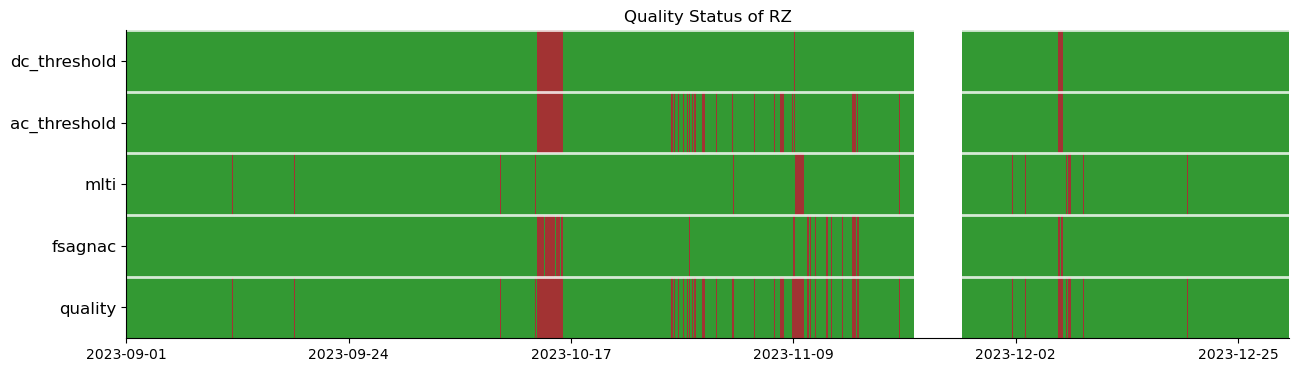

In [11]:
fig = __makelplot_single_status(statusU, "U")
fig = __makelplot_single_status(statusV, "V")
fig = __makelplot_single_status(statusZ, "Z")


# print(f" -> stored: {config['path_to_figures']}R{config['ring']}_{config['tbeg'].date}_status.png")
# fig.savefig(config['path_to_figures']+f"R{config['ring']}_{config['tbeg'].date}_status.png", format="png", dpi=100, bbox_inches='tight')

In [12]:
## create sub-frames
statusZ_mod = statusZ[['times_utc','quality']]
statusU_mod = statusU[['times_utc','quality']]
statusV_mod = statusV[['times_utc','quality']]

## remove NaN from times
statusZ_mod = statusZ_mod.dropna(subset="times_utc").reset_index()
statusV_mod = statusV_mod.dropna(subset="times_utc").reset_index()
statusU_mod = statusU_mod.dropna(subset="times_utc").reset_index()

# statusZ_mod.shape, statusU_mod.shape, statusV_mod.shape

## make times all to string objects
statusZ_mod['times_utc'] = statusZ_mod.times_utc.astype(str)
statusU_mod['times_utc'] = statusU_mod.times_utc.astype(str)
statusV_mod['times_utc'] = statusV_mod.times_utc.astype(str)

In [13]:
## create new frame with all rings and their quality
df_new = statusZ_mod.copy()

print(df_new)


df_new = df_new.merge(statusU_mod, how="outer", on=["times_utc"])

print(df_new)

df_new = df_new.merge(statusV_mod, how="outer", on=["times_utc"])

print(df_new)

## drop irrelevant columns
df_new.drop(columns=["index_x", "index_y", "index"], inplace=True)

## renaming ...
df_new.rename(columns={"quality_x":"RZ", "quality_y":"RU", "quality":"RV"}, inplace=True)

## add relative times
ref_time = df_new.times_utc.iloc[0]
df_new['times_utc_sec'] = np.array([abs(obs.UTCDateTime(ref_time) - obs.UTCDateTime(_t) +30) for _t in df_new.times_utc])

## add RW column
df_new['RW'] = np.ones(df_new.shape[0])*np.nan

## sort all by time
df_new.sort_values(by="times_utc", inplace=True)

        index                    times_utc  quality
0           3  2023-09-01T00:00:30.000000Z      1.0
1           4  2023-09-01T00:01:30.000000Z      1.0
2           5  2023-09-01T00:02:30.000000Z      1.0
3           6  2023-09-01T00:03:30.000000Z      1.0
4           7  2023-09-01T00:04:30.000000Z      1.0
...       ...                          ...      ...
239240   1438  2023-12-30T23:55:30.000000Z      1.0
239241   1439  2023-12-30T23:56:30.000000Z      1.0
239242      0  2023-12-30T23:57:30.000000Z      1.0
239243      1  2023-12-30T23:58:30.000000Z      1.0
239244      2  2023-12-30T23:59:30.000000Z      1.0

[239245 rows x 3 columns]
        index_x                    times_utc  quality_x  index_y  quality_y
0           3.0  2023-09-01T00:00:30.000000Z        1.0      3.0        1.0
1           4.0  2023-09-01T00:01:30.000000Z        1.0      4.0        1.0
2           5.0  2023-09-01T00:02:30.000000Z        1.0      5.0        1.0
3           6.0  2023-09-01T00:03:30.000000Z 

/tmp/ipykernel_196622/1314500459.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tcklbls)


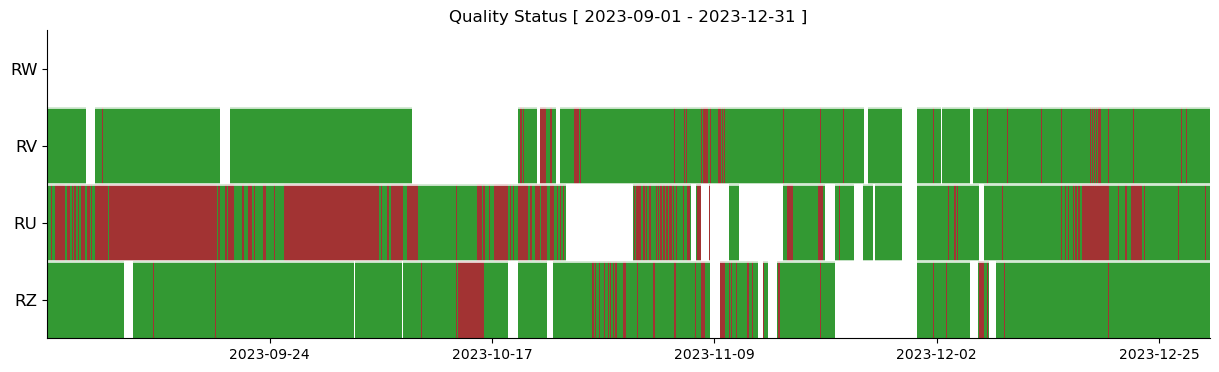

In [14]:
def __makelplot_all_status(df):

    names = ["RZ", "RU", "RV", "RW"]

    ## make statistics
    df_stats = DataFrame(columns=["ring", "R_0", "R_1", "R_nan", "R_N", "R_0_p", "R_1_p", "R_nan_p"])

    R_0, R_1, R_nan = np.zeros(len(names)), np.zeros(len(names)), np.zeros(len(names))
    for _n, k in enumerate(names):

        R_0 = df_new[k][df_new[k] == 0].size
        R_1 = df_new[k][df_new[k] == 1].size
        R_nan = df_new[k][df_new[k].isnull()].size
        R_N = df_new[k].size

        R_0_p = round(R_0/R_N*100, 2)
        R_1_p = round(R_1/R_N*100, 2 )
        R_nan_p = round(R_nan/R_N*100, 2)

        df_stats.loc[len(df_stats)] = [k, R_0, R_1, R_nan, R_N, R_0_p, R_1_p, R_nan_p]


    bars = np.ones(4)-0.5

    arr = np.ones((4, df.shape[0]))

    for _n, name in enumerate(names):
        arr[_n] *= df[name]

    time_scaling = 1

    cmap = matplotlib.colors.ListedColormap(['darkred', 'green'])

    font = 12

    fig, ax = plt.subplots(1, 1, figsize=(15, 4))

    c = ax.pcolormesh(df.times_utc_sec*time_scaling, names, arr, cmap=cmap, rasterized=True, alpha=0.8)

    for _k, bar in enumerate(bars):
        ax.axhline(bar+_k, color="w", alpha=0.8, lw=2)

    # ax.set_xlabel("Time (days)")

    ax.set_title(f"Quality Status [ {config['tbeg'].date} - {config['tend'].date} ]")

    ## add dates for x-axis
    ref_date = df.times_utc.iloc[0]
    tcks = ax.get_xticks()
    tcklbls = [str((obs.UTCDateTime(ref_date)+t).date) for t in tcks]
    ax.set_xticklabels(tcklbls)

    ax.tick_params(axis='y', labelsize=font)
    ax.tick_params(axis='x', labelsize=font-2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show();
    return fig

fig = __makelplot_all_status(df_new);


In [15]:
df_stats = DataFrame(columns=["ring", "R_0", "R_1", "R_nan", "R_N", "R_0_p", "R_1_p", "R_nan_p"])

rings = ['RZ', 'RU', 'RV', 'RW']

R_0, R_1, R_nan = np.zeros(len(rings)), np.zeros(len(rings)), np.zeros(len(rings))
for _n, k in enumerate(rings):

    R_0 = df_new[k][df_new[k] == 0].size
    R_1 = df_new[k][df_new[k] == 1].size
    R_nan = df_new[k][df_new[k].isnull()].size
    R_N = df_new[k].size

    R_0_p = round(R_0/R_N*100,2)
    R_1_p = round(R_1/R_N*100,2 )
    R_nan_p = round(R_nan/R_N*100, 2)

    df_stats.loc[len(df_stats)] = [k, R_0, R_1, R_nan, R_N, R_0_p, R_1_p, R_nan_p]

df_stats

,ring,R_0,R_1,R_nan,R_N,R_0_p,R_1_p,R_nan_p
0,RZ,13232,224573,105636,343441,3.85,65.39,30.76
1,RU,98919,130010,114512,343441,28.80,37.86,33.34
2,RV,29811,205475,108155,343441,8.68,59.83,31.49
3,RW,0,0,343441,343441,0.00,0.00,100.00


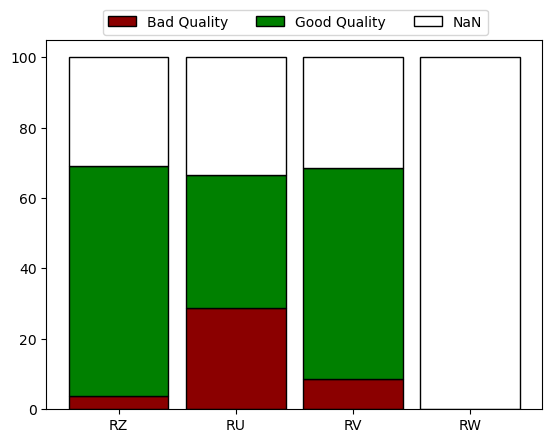

In [43]:
barWidth = 0.85
r = range(df_stats.ring.size)

plt.bar(r, df_stats.R_0_p,
        color='darkred', edgecolor='k', width=barWidth, label="Bad Quality")

plt.bar(r, df_stats.R_1_p, bottom=df_stats.R_0_p,
        color='green', edgecolor='k', width=barWidth, label="Good Quality")

plt.bar(r, df_stats.R_nan_p, bottom=[i+j for i,j in zip(df_stats.R_0_p, df_stats.R_1_p)],
        color='white', edgecolor='k', width=barWidth, label="NaN")

plt.xticks(r, df_stats.ring)
# plt.xlabel("group")

plt.legend(loc='upper left', bbox_to_anchor=(0.1, 1.1), ncol=3)


# for n in df_stats.iloc[:, 5:]:
#     for i, (cs, ab, pc) in enumerate(zip(df_stats.iloc[:, 1:].cumsum(1)[n], df_stats[n], df_stats[n])):
#         plt.text(cs - ab / 2, i, str(np.round(pc, 1)) + '%', va = 'center', ha = 'center')

plt.show()

In [41]:
for n in df_stats.iloc[:,5:]:
    for i, (cs, ab, pc) in enumerate(zip(df_stats.iloc[:, 1:].cumsum(1)[n], df_stats[n], df_stats[n])):
        plt.text(cs - ab / 2, i, str(np.round(pc, 1)) + '%', va = 'center', ha = 'center')

ValueError: Image size of 340735517x1159 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

In [39]:
df_stats.iloc[:,5:]

,R_0_p,R_1_p,R_nan_p
0,3.85,65.39,30.76
1,28.80,37.86,33.34
2,8.68,59.83,31.49
3,0.00,0.00,100.00
